In [6]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from PIL import Image

In [7]:
classes = ['class_0','class_1']
class_1_speakers = ['f1','f7','f8','m3','m6','m8']
filepath = 'daps/cleanraw' # Only using clean raw data for Milestone #1
sample_rate = 44100 # Obtained from the EDA
os.makedirs('spectrograms', exist_ok=True)
for cl in classes:
    os.makedirs(os.path.join('spectrograms',cl),exist_ok=True)

In [20]:
def load_audio_files():
    audio_files = {
        'class_0': [],
        'class_1': []
        }
    for file in os.listdir(filepath):
        audio, _ = librosa.load(os.path.join(filepath, file),sr=None)
        trimmed, _ = librosa.effects.trim(audio, top_db=20)
        if(file.split('_')[0] in class_1_speakers):
            audio_files['class_1'].append(trimmed)
        else:
            audio_files['class_0'].append(trimmed)
    return audio_files

audio = load_audio_files()

In [21]:
def split_audio(audio,duration = 5.0):
    samples_per_segment = duration * sample_rate
    segments = len(audio)
    return np.array_split(audio, int(segments/samples_per_segment))

def time_shift(audio, max_shift = 2.5):
    shift = np.random.uniform(-max_shift, max_shift)
    shift_samples = int(shift * sample_rate)
    return np.roll(audio, shift_samples)

In [47]:
def generate_spectrograms(class_label, duration = 5.0, max_shift = 2.5, shifts = None):
    spectrograms = []
    for au in tqdm(audio[class_label],desc=f"Processing audio files of {class_label}"):

        to_split = [au]
        if shifts is not None:
                for _ in range(shifts):
                    to_split.append(time_shift(au, max_shift))
        for sp in to_split:
            segments = split_audio(sp, duration)

            for segment in segments:
                S = librosa.feature.melspectrogram(y=segment, sr=sample_rate)
                S_dB = librosa.power_to_db(S, ref=np.max)
                spectrograms.append(S_dB)

    return spectrograms

In [50]:
def process_classes():
    spectrograms = {
        'class_0': generate_spectrograms('class_0'),
        'class_1': generate_spectrograms('class_1',shifts=1)
    }

    for class_label in classes:
        i = 0
        for spectrogram in tqdm(spectrograms[class_label], desc=f'Processing {class_label}'):
            plt.figure(figsize=(2, 2))
            librosa.display.specshow(spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
            # plt.colorbar(format='%+2.0f dB')
            # plt.title(class_label)
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join('spectrograms', class_label, f'{class_label}_{i+1}.png'), bbox_inches='tight', pad_inches=0)
            plt.close()
            i+=1
            # plt.show()


In [51]:
process_classes()

Processing class_1: 100%|██████████| 1866/1866 [02:55<00:00, 10.64it/s]


In [52]:
print("class_0 images:",len(os.listdir('spectrograms/class_0')))
print("class_1 images:", len(os.listdir('spectrograms/class_1')))

class_0 images: 2077
class_1 images: 1866


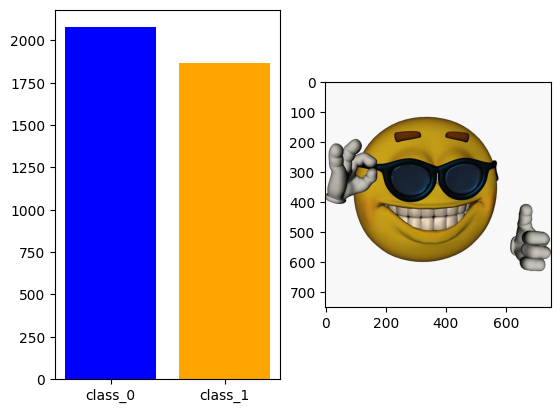

In [60]:
img = Image.open('ok.jpg')
plt.subplot(1,2,1)
plt.bar(x=classes,height=[len(os.listdir('spectrograms/class_0')),len(os.listdir('spectrograms/class_1'))],color=['blue','orange'])
plt.subplot(1,2,2)
plt.imshow(img)
plt.show()

### Now classes are git balans

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

dataset = torchvision.datasets.ImageFolder(root='spectrograms', transform=transform)

trainset, testset = torch.utils.data.random_split(dataset, [0.8,0.2])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

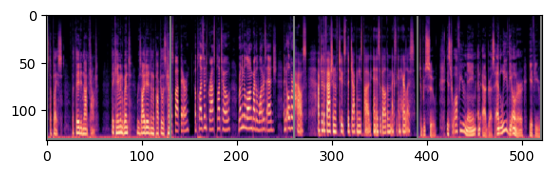

class_1 class_1 class_1 class_1


In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 29 * 29, 128)
        self.fc2 = nn.Linear(128, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [12]:
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=26912, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
for epoch in range(20):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.694
[1,   400] loss: 0.688
[1,   600] loss: 0.680
[2,   200] loss: 0.641
[2,   400] loss: 0.637
[2,   600] loss: 0.529
[3,   200] loss: 0.284
[3,   400] loss: 0.188
[3,   600] loss: 0.167
[4,   200] loss: 0.137
[4,   400] loss: 0.088
[4,   600] loss: 0.079
[5,   200] loss: 0.054
[5,   400] loss: 0.056
[5,   600] loss: 0.042
[6,   200] loss: 0.029
[6,   400] loss: 0.026
[6,   600] loss: 0.041
[7,   200] loss: 0.040
[7,   400] loss: 0.005
[7,   600] loss: 0.008
[8,   200] loss: 0.009
[8,   400] loss: 0.017
[8,   600] loss: 0.004
[9,   200] loss: 0.001
[9,   400] loss: 0.001
[9,   600] loss: 0.001
[10,   200] loss: 0.000
[10,   400] loss: 0.000
[10,   600] loss: 0.000
[11,   200] loss: 0.000
[11,   400] loss: 0.000
[11,   600] loss: 0.000
[12,   200] loss: 0.000
[12,   400] loss: 0.000
[12,   600] loss: 0.000
[13,   200] loss: 0.000
[13,   400] loss: 0.000
[13,   600] loss: 0.000
[14,   200] loss: 0.000
[14,   400] loss: 0.000
[14,   600] loss: 0.000
[15,   200] loss: 0

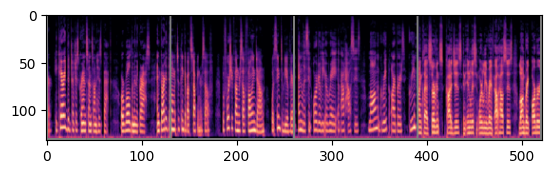

GroundTruth:  class_1 class_1 class_0 class_0


In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter)


# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
images, labels = images.to(device), labels.to(device)

In [16]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  class_1 class_1 class_0 class_0


In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 3954 test images: {100 * correct // total} %')

Accuracy of the network on the 3954 test images: 97 %


In [18]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: class_0 is 98.3 %
Accuracy for class: class_1 is 97.6 %


Accuracy: 97.97%
F1 Score: 0.98


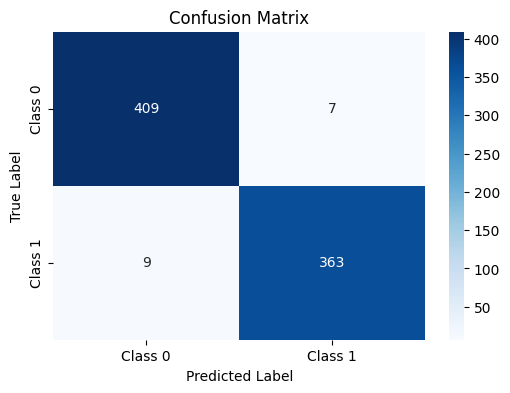

In [19]:
import sklearn.metrics as skm
import seaborn as sns
# Evaluation on test set with F1 score and confusion matrix
net.eval()
all_labels = []
all_predictions = []
correct, total = 0, 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Track total and correct for accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Append results for F1 score and confusion matrix calculation
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = 100 * correct / total
f1 = skm.f1_score(y_true=all_labels, y_pred=all_predictions,average='macro')
conf_matrix = skm.confusion_matrix(all_labels, all_predictions)

print(f"Accuracy: {accuracy:.2f}%")
print(f"F1 Score: {f1:.2f}")


# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [20]:
torch.save(net.state_dict(),'model.pth')

In [ ]:
net = Net()
net.load_state_dict(torch.load('model.pth', weights_only=True))
net.to(device)